# <span style="color:red">**Libraries**</span>

In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time

# <span style="color:red">**Functions**</span>

In [3]:
def time_function(func, *args, **kwargs):
    """
    Times the execution of a function.
    
    Parameters:
        func (callable): The function to be timed.
        *args: Positional arguments to pass to `func`.
        **kwargs: Keyword arguments to pass to `func`.
    
    Returns:
        tuple: (result, elapsed_time_in_seconds)
    """
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    elapsed = end - start
    return elapsed

In [4]:
def is_business_day(date, calendar=USFederalHolidayCalendar()):
    """
    Checks if a given date is a business day.

    Parameters:
        date (datetime): The date to check.
        calendar (AbstractHolidayCalendar, optional): A holiday calendar to consider. Defaults to USFederalHolidayCalendar().

    Returns:
        bool: True if the date is a business day, False otherwise.
    """
    bday_range = pd.bdate_range(start=date, end=date, freq='C', holidays=calendar.holidays())
    return len(bday_range) > 0

In [5]:
def get_day_of_week(date):
    """
    Returns the day of the week for a given date.

    Parameters:
        date (datetime): The date for which the day of the week is to be determined.

    Returns:
        str: The name of the day of the week (e.g., 'Monday', 'Tuesday').
    """
    return date.strftime('%A')

In [6]:
def generate_resources(n=5,ini_seed=42):
    """
    Generates a DataFrame of resources with random attributes.

    Parameters:
        n (int): The number of resources to generate. Defaults to 5.
        ini_seed (int): The seed for random number generation. Defaults to 42.

    Returns:
        pd.DataFrame: A DataFrame containing the generated resources with the following columns:
            - resources_id: Unique identifier for the resource.
            - skill_level: Skill level of the resource (1 to 3).
            - spoken_languages: Set of languages spoken by the resource.
            - Monday, Tuesday, Wednesday, Thursday, Friday: Hours available on each weekday.
            - cost_per_hour: Cost per hour for the resource, calculated based on skill level and languages spoken.
    """
    random.seed(ini_seed)
    resources = []
    for i in range(1, n + 1):
        resources.append({
            "resources_id": i,
            "skill_level": random.randint(1, 3),
            "spoken_languages": set(random.sample(["English", "Spanish"], random.randint(1, 2))),
            "Monday": random.randint(0, 8),
            "Tuesday": random.randint(0, 8),
            "Wednesday": random.randint(0, 8),
            "Thursday": random.randint(0, 8),
            "Friday": random.randint(0, 8),
        })
        resources[-1]["cost_per_hour"] = resources[-1]["skill_level"] * 10 + len(resources[-1]["spoken_languages"]) * 5
    return pd.DataFrame(resources)


In [7]:
def generate_demands(n=5,ini_seed=42):
    """
    Generates a DataFrame of demands with random attributes.

    Parameters:
        n (int): The number of demands to generate. Defaults to 5.
        ini_seed (int): The seed for random number generation. Defaults to 42.

    Returns:
        pd.DataFrame: A DataFrame containing the generated demands with the following columns:
            - demands_id: Unique identifier for the demand.
            - skill_required: Skill level required for the demand (1 to 3).
            - languages_required: Set of languages required for the demand.
            - begin_date: Start date of the demand.
            - end_date: End date of the demand.
            - total_workload: Total workload required to complete the demand.
            - revenue: Revenue generated upon completing the demand.
            - cost_not_completed: Penalty cost if the demand is not completed.
    """
    random.seed(ini_seed)
    demands = []
    for i in range(1, n + 1):
        demands.append({
            "demands_id": i,
            "skill_required": random.randint(1, 3),
            "languages_required": set(random.sample(["English", "Spanish"], random.randint(1, 2))),
            "begin_date": datetime(2025, 3, random.randint(3, 5)),
            "end_date": datetime(2025, 3, random.randint(6, 15))
        })
        available_days = (demands[-1]["end_date"] - demands[-1]["begin_date"]).days + 1 
        demands[-1]["total_workload"] = available_days * random.randint(1, 4)
        demands[-1]["revenue"] = demands[-1]["skill_required"] * 500 + len(demands[-1]["languages_required"]) * 200 + demands[-1]['total_workload'] * 100
        demands[-1]["cost_not_completed"] = demands[-1]["revenue"] * 0.2
    return pd.DataFrame(demands)

In [8]:
def simulate_first_day(demands, resources, today, assignments_log):
    """
    Simulates the first day of resource allocation.

    Parameters:
        demands (pd.DataFrame): DataFrame containing the initial demand details.
        resources (pd.DataFrame): DataFrame containing the initial resource details.
        today (datetime): The current date for the simulation.
        assignments_log (dict): Dictionary to log assignments for each day. In this function, it begins with an empty dictionary.

    Returns:
        tuple: A tuple containing:
            - demands_end_day (pd.DataFrame): Updated demands DataFrame after the first day.
            - resources_end_day (pd.DataFrame): Updated resources DataFrame after the first day.
            - day_cost (float): Total cost incurred on the first day.
    """
    # Determine the day of the week for the current simulation day
    day_of_week = get_day_of_week(today)
    day_cost = 0  # Initialize the total cost for the day
    assignments_today = []  # List to store today's assignments

    # Filter active demands for the current day and shuffle them for fairness
    active_demands = demands[
        (demands['begin_date'] <= today) & (demands['end_date'] >= today)
    ].sample(frac=1).reset_index(drop=True)

    # Prepare end-of-day state for demands and resources
    demands_end_day = demands.copy()
    resources_end_day = resources.copy()
    resources_end_day['allocated_to_demand'] = -1  # Initialize allocation status, since it is the first day, all unalocated
    demands_end_day['allocated_to_resource'] = -1  # Initialize allocation status, since it is the first day, all are free

    # Set indices for fast lookups
    demands_end_day.set_index('demands_id', inplace=True)
    resources_end_day.set_index('resources_id', inplace=True)

    # Precompute available hours and costs for resources
    res_avail_today = resources_end_day[day_of_week]
    res_cost = resources_end_day['cost_per_hour']
    holiday_calendar = USFederalHolidayCalendar().holidays()

    for _, demand in active_demands.iterrows():
        dem_id = demand['demands_id']

        # Filter resources that are available and not yet allocated
        available = resources_end_day[
            (res_avail_today > 0) & (resources_end_day['allocated_to_demand'] == -1)
        ]

        # Match resources based on skill level
        skill_match = available[available['skill_level'] >= demand['skill_required']]
        if skill_match.empty:
            continue  # Skip if no resources match the skill requirement

        # Match resources based on language requirements
        required_langs = demand['languages_required']
        lang_match = skill_match[
            skill_match['spoken_languages'].apply(lambda langs: langs.issuperset(required_langs))
        ]
        if lang_match.empty:
            continue  # Skip if no resources match the language requirement

        # Calculate the number of available workdays for the demand
        bdays = pd.bdate_range(start=today, end=demand['end_date'], freq='C', holidays=holiday_calendar)
        weekday_counts = pd.Series([get_day_of_week(day) for day in bdays]).value_counts()
        weekday_cols = weekday_counts.index.intersection(lang_match.columns)

        # Calculate total time available for each resource
        lang_match = lang_match.copy()
        lang_match['time_available_for_task'] = lang_match[weekday_cols].multiply(weekday_counts, axis=1).sum(axis=1)

        # Filter resources that have enough time to complete the demand
        enough_time = lang_match[lang_match['time_available_for_task'] >= demand['total_workload']]
        if enough_time.empty:
            continue  # Skip if no resources have enough time

        # Select the cheapest resource among those that meet the requirements
        min_cost = enough_time['cost_per_hour'].min()
        selected = enough_time[enough_time['cost_per_hour'] == min_cost].sample(n=1)
        sel_id = selected.index[0]

        # Calculate the workload for today
        today_workload = min(selected.at[sel_id, day_of_week], demand['total_workload'])
        day_cost += selected.at[sel_id, 'cost_per_hour'] * today_workload

        # Update the state of demands and resources
        demands_end_day.at[dem_id, 'total_workload'] -= today_workload
        demands_end_day.at[dem_id, 'allocated_to_resource'] = sel_id
        resources_end_day.at[sel_id, 'allocated_to_demand'] = dem_id

        # Log today's assignments if any work was done
        if today_workload > 0:
            assignments_today.append((sel_id, dem_id))

    # Log the assignments for the current day
    assignments_log[today] = assignments_today

    # Return the updated states and the total cost for the day
    return demands_end_day.reset_index(), resources_end_day.reset_index(), day_cost


In [9]:
def update_dataframes(demands, resources):
    """
    Updates the demands and resources DataFrames by resetting the allocation status for completed demands.

    Parameters:
        demands (pd.DataFrame): DataFrame containing demand details.
        resources (pd.DataFrame): DataFrame containing resource details.

    Returns:
        tuple: A tuple containing:
            - demands_updated (pd.DataFrame): Updated demands DataFrame with allocation status reset for completed demands.
            - resources_updated (pd.DataFrame): Updated resources DataFrame with allocation status reset for resources assigned to completed demands.
    """
    resources_updated = resources.copy()
    demands_updated = demands.copy()
    finished_demands_list = demands[demands['total_workload'] <= 0]['demands_id'].to_list()
    demands_updated.loc[demands_updated['total_workload'] <= 0, 'allocated_to_resource'] = -1
    resources_updated.loc[resources_updated['allocated_to_demand'].isin(finished_demands_list), 'allocated_to_demand'] = -1
    return  demands_updated , resources_updated

In [10]:
def simulate_second_day_and_beyond(demands, resources, today, assignments_log):
    """
    Simulates resource allocation for the second day and beyond.

    Parameters:
        demands (pd.DataFrame): DataFrame containing demand details.
        resources (pd.DataFrame): DataFrame containing resource details.
        today (datetime): The current date for the simulation.
        assignments_log (dict): Dictionary to log assignments for each day.

    Returns:
        tuple: A tuple containing:
            - demands_end_day (pd.DataFrame): Updated demands DataFrame after the simulation day.
            - resources_end_day (pd.DataFrame): Updated resources DataFrame after the simulation day.
            - day_cost (float): Total cost incurred on the simulation day.
    """
    day_cost = 0
    day_of_week = get_day_of_week(today)  # Determine the current day of the week
    assignments_today = []  # List to store today's assignments
    resources_end_day = resources.copy()  # Copy resources DataFrame to avoid modifying the original
    demands_end_day = demands.copy()  # Copy demands DataFrame to avoid modifying the original

    # Set indices for faster lookups
    demands_end_day.set_index('demands_id', inplace=True)
    resources_end_day.set_index('resources_id', inplace=True)

    # Filter demands that are in progress and have remaining workload
    in_progress_demands = demands[
        (demands['begin_date'] <= today) & 
        (demands['end_date'] >= today) & 
        (demands['total_workload'] > 0)
    ]

    # Separate demands into allocated and unallocated
    allocated_demands = in_progress_demands[in_progress_demands['allocated_to_resource'] != -1]
    to_do_demands = in_progress_demands[in_progress_demands['allocated_to_resource'] == -1].sample(frac=1).reset_index(drop=True)

    # Precompute resource availability and costs for the current day
    daily_resource_hours = resources_end_day[day_of_week]
    cost_per_hour = resources_end_day['cost_per_hour']

    # Process demands that are already allocated to resources
    for _, demand in allocated_demands.iterrows():
        res_id = demand['allocated_to_resource']
        dem_id = demand['demands_id']

        available = daily_resource_hours[res_id]  # Available hours for the resource
        required = demands_end_day.at[dem_id, 'total_workload']  # Remaining workload for the demand
        workload = min(available, required)  # Allocate as much as possible within available hours

        # Update cost and workload
        day_cost += cost_per_hour[res_id] * workload
        demands_end_day.at[dem_id, 'total_workload'] -= workload

        # Log the assignment if any workload was allocated
        if workload > 0:
            assignments_today.append((res_id, dem_id))

    # Precompute holidays for business day calculations
    holidays = USFederalHolidayCalendar().holidays()
    
    # Process unallocated demands
    for _, demand in to_do_demands.iterrows():
        # Filter resources that are not already allocated and have availability today
        available_resources = resources_end_day[
            (resources_end_day['allocated_to_demand'] == -1) & 
            (resources_end_day[day_of_week] > 0)
        ]
        if available_resources.empty:
            continue

        # Filter resources by skill level
        skill_match = available_resources[available_resources['skill_level'] >= demand['skill_required']]
        if skill_match.empty:
            continue

        # Filter resources by language requirements
        lang_req = demand['languages_required']
        language_match = skill_match[skill_match['spoken_languages'].apply(lambda langs: langs.issuperset(lang_req))]
        if language_match.empty:
            continue

        # Calculate business days between today and the demand's end date
        biz_days = pd.bdate_range(start=today, end=demand['end_date'], freq='C', holidays=holidays)
        weekday_counts = pd.Series([get_day_of_week(day) for day in biz_days]).value_counts()

        # Estimate available time for each resource
        time_avail = (
            language_match[weekday_counts.index].multiply(weekday_counts, axis=1).sum(axis=1)
        )
        enough_hours = language_match[time_avail >= demand['total_workload']].copy()

        if enough_hours.empty:
            continue

        # Select the most cost-effective resource
        min_cost = enough_hours['cost_per_hour'].min()
        most_cost_effective = enough_hours[enough_hours['cost_per_hour'] == min_cost]
        selected_resource = most_cost_effective.sample(n=1)
        res_id = selected_resource.index[0]
        workload = min(selected_resource[day_of_week].values[0], demand['total_workload'])
        dem_id = demand['demands_id']

        # Update workload, cost, and assignments
        demands_end_day.at[dem_id, 'total_workload'] -= workload
        day_cost += selected_resource['cost_per_hour'].values[0] * workload
        resources_end_day.at[res_id, 'allocated_to_demand'] = dem_id
        demands_end_day.at[dem_id, 'allocated_to_resource'] = res_id
        if workload > 0:
            assignments_today.append((res_id, dem_id))

    # Log today's assignments
    assignments_log[today] = assignments_today
    
    # Reset indices before returning the updated DataFrames
    return demands_end_day.reset_index(), resources_end_day.reset_index(), day_cost


In [11]:
def simulate_monte_carlo_step(demands, resources, today):
    """
    Simulates a single step of the Monte Carlo simulation for resource allocation.

    Parameters:
        demands (pd.DataFrame): DataFrame containing demand details.
        resources (pd.DataFrame): DataFrame containing resource details.
        today (datetime): The starting date for the simulation.

    Returns:
        tuple: A tuple containing:
            - assignments_log (dict): A dictionary logging resource-to-demand assignments for each day.
            - simulation_summary (dict): A dictionary summarizing the simulation results, including:
                - profit (float): The total profit from the simulation.
                - total_cost (float): The total cost incurred during the simulation.
                - works_completed (int): The number of demands successfully completed.
                - works_not_completed (int): The number of demands not completed.
    """
    # Initialize the assignments log and total cost
    assignments_log = {}
    total_cost = 0

    # Determine the first and last days of the simulation
    first_day = today
    last_day = demands['end_date'].max()

    # Simulate the first day
    demands_end_day, resources_end_day, day_cost = simulate_first_day(demands, resources, first_day, assignments_log)
    demands_end_day, resources_end_day = update_dataframes(demands_end_day, resources_end_day)
    total_cost += day_cost  # Accumulate the cost for the first day

    # Simulate subsequent days
    for date in pd.date_range(start=first_day + pd.DateOffset(days=1), end=last_day):
        if is_business_day(date):  # Check if the current day is a business day
            demands_end_day, resources_end_day, day_cost = simulate_second_day_and_beyond(demands_end_day, resources_end_day, date, assignments_log)
            demands_end_day, resources_end_day = update_dataframes(demands_end_day, resources_end_day)
            total_cost += day_cost  # Accumulate the cost for the current day

    # Separate completed and not completed demands
    df_completed = demands_end_day[demands_end_day['total_workload'] <= 0]
    df_not_completed = demands_end_day[demands_end_day['total_workload'] > 0]

    # Add penalty costs for not completed demands
    total_cost += df_not_completed['cost_not_completed'].sum()

    # Calculate profit
    profit = df_completed['revenue'].sum() - total_cost

    # Summarize the simulation results
    works_completed = df_completed.shape[0]
    works_not_completed = df_not_completed.shape[0]
    simulation_summary = {
        "profit": profit,
        "total_cost": total_cost,
        "works_completed": works_completed,
        "works_not_completed": works_not_completed
    }

    return assignments_log, simulation_summary

In [12]:
def plot_bipartite(assignments, day):
    """
    Plots a bipartite graph representing resource-to-demand assignments for a given day.

    Parameters:
        assignments (dict): A dictionary where keys are dates and values are lists of tuples (resource_id, demand_id),
                            representing the assignments for each day.
        day (datetime or Timestamp): The specific day for which the bipartite graph is to be plotted.

    Returns:
        None: Displays the bipartite graph for the given day.
    """
    # Get the list of edges (assignments) for the given day
    edges = assignments.get(day, [])
    if not edges:
        print(f"No assignments on {day}")  # Print a message if no assignments exist for the day
        return

    # Sort edges for consistent vertical alignment in the graph
    edges = sorted(edges, key=lambda x: (x[0], x[1]))

    # Create a bipartite graph
    B = nx.Graph()

    # Create nodes for resources and demands
    resource_nodes = [f"res_{r}" for r, _ in edges]  # Prefix resource nodes with "res_"
    demand_nodes = [f"dem_{d}" for _, d in edges]    # Prefix demand nodes with "dem_"
    B.add_nodes_from(resource_nodes, bipartite=0)    # Add resource nodes to one partition
    B.add_nodes_from(demand_nodes, bipartite=1)      # Add demand nodes to the other partition

    # Add edges between resource and demand nodes
    B.add_edges_from(zip(resource_nodes, demand_nodes))

    # Define positions for nodes to align them in two vertical columns
    pos = {}
    for i, (r, d) in enumerate(edges):
        pos[f"res_{r}"] = (0, -i)  # Position resources in the left column
        pos[f"dem_{d}"] = (1, -i)  # Position demands in the right column

    # Plot the bipartite graph
    plt.figure(figsize=(8, len(edges) * 0.5))  # Adjust figure size based on the number of edges
    nx.draw(
        B, pos, with_labels=True,
        node_color=["skyblue" if n.startswith("res_") else "lightgreen" for n in B.nodes()],  # Color nodes by type
        edge_color="gray"  # Set edge color
    )
    plt.title(f"Assignment Graph — {day.strftime('%Y-%m-%d')}")  # Add a title with the date
    plt.axis("off")  # Turn off the axis for better visualization
    plt.show()  # Display the graph

In [13]:
def plot_simulation_profits(simulation_summary_list):
    """
    Plots a histogram of profits from the simulation summary list.

    Parameters:
        simulation_summary_list (list): A list of dictionaries containing simulation summaries, 
                                        each with a 'profit' key.

    Returns:
        None: Displays the histogram plot.
    """
    # Extract profits from the simulation summary list
    profits = [summary['profit'] for summary in simulation_summary_list]

    # Create a histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(profits, bins=50, kde=True, color='blue')
    plt.title('Histogram of Profits from Simulation')
    plt.xlabel('Profit')
    plt.ylabel('Count')
    plt.show()


In [14]:
def get_best_simulation_summary(simulation_summary_list):
    """
    Finds the best simulation summary with the maximum profit.

    Parameters:
        simulation_summary_list (list): A list of dictionaries containing simulation summaries.

    Returns:
        dict: The best simulation summary with the maximum profit.
    """
    # Find the index of the maximum profit
    profits = [summary['profit'] for summary in simulation_summary_list]
    max_profit_index = profits.index(max(profits))

    # Retrieve the corresponding simulation summary
    best_summary = simulation_summary_list[max_profit_index]
    print(f"Best Simulation Summary: {best_summary}")
    print(f"Maximum Profit: {profits[max_profit_index]}")

In [15]:
def plot_best_simulation(simulation_summary_list, assignments_log_list):
    """
    Plots the bipartite graphs for the best simulation based on maximum profit.

    Parameters:
        simulation_summary_list (list): A list of dictionaries containing simulation summaries.
        assignments_log_list (list): A list of dictionaries logging resource-to-demand assignments for each simulation.

    Returns:
        None: Displays the bipartite graphs for the best simulation.
    """
    # Find the index of the simulation with the maximum profit
    profits = [summary['profit'] for summary in simulation_summary_list]
    max_profit_index = profits.index(max(profits))
    
    # Get the assignments log for the best simulation
    best_assignments_log = assignments_log_list[max_profit_index]
    
    # Plot the bipartite graph for each day in the best simulation
    for day in sorted(best_assignments_log):
        plot_bipartite(best_assignments_log, day)

# <span style="color:red">**Simulation**</span>

In [16]:
resources_example = pd.DataFrame([
    {"resources_id": 1,"skill_level": 2, "spoken_languages": {"English", "Spanish"}, "cost_per_hour": 40, "Monday": 8, "Tuesday": 8, "Wednesday": 4, "Thursday": 4, "Friday": 4},
    {"resources_id": 2,"skill_level": 2, "spoken_languages": {"English", "Spanish"}, "cost_per_hour": 40, "Monday": 2, "Tuesday": 2, "Wednesday": 2, "Thursday": 2, "Friday": 2},
    {"resources_id": 3,"skill_level": 2, "spoken_languages": {"English"}, "cost_per_hour": 30, "Monday": 8, "Tuesday": 8, "Wednesday": 8, "Thursday": 8, "Friday": 8},
])

demands_example = pd.DataFrame([
    {"demands_id": 1, "skill_required": 2, "languages_required": {"English", "Spanish"}, 
     "total_workload": 20, 
     "begin_date": datetime(2025,3,3), 
     "end_date": datetime(2025,3,7),
     "revenue": 1500,
     "cost_not_completed":300}
])

In [17]:
n_simulations = 300
today = datetime(2025, 3, 3)
week_days = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday']
n_demands = 100
n_resources = n_demands * 3 

In [18]:

demands = generate_demands(n_demands)
resources = generate_resources(n_resources)

In [19]:
demands.head()

,demands_id,skill_required,languages_required,begin_date,end_date,total_workload,revenue,cost_not_completed
0,1,3,{English},2025-03-05,2025-03-10,12,2900,580.0
1,2,1,{English},2025-03-05,2025-03-14,10,1700,340.0
2,3,3,"{Spanish, English}",2025-03-03,2025-03-09,14,3300,660.0
3,4,3,{English},2025-03-05,2025-03-14,40,5700,1140.0
4,5,1,"{Spanish, English}",2025-03-03,2025-03-12,30,3900,780.0


In [20]:
resources.head()

,resources_id,skill_level,spoken_languages,Monday,Tuesday,Wednesday,Thursday,Friday,cost_per_hour
0,1,3,{English},4,3,3,2,1,35
1,2,3,{Spanish},0,0,1,3,3,35
2,3,3,{English},8,6,3,7,4,35
3,4,1,{Spanish},5,4,2,3,5,15
4,5,1,{Spanish},1,5,5,4,0,15


In [21]:
expected_time_finish_simulation = time_function(simulate_monte_carlo_step, demands, resources, today)
expected_time_finish_simulation = (expected_time_finish_simulation * n_simulations) / 60 
print(f"Expected time to finish {n_simulations} simulations: {expected_time_finish_simulation:.2f} minutes")

Expected time to finish 300 simulations: 26.56 minutes


In [22]:
assignments_log_list = []
simulation_summary_list = []
for i in range(n_simulations):
    assignments_log , simulation_summary = simulate_monte_carlo_step(demands,resources,today)
    assignments_log_list.append(assignments_log)
    simulation_summary_list.append(simulation_summary)

# <span style="color:red">**Introduction**</span>

This notebook demonstrates a resource allocation and demand fulfillment simulation using a Monte Carlo approach. 
The goal is to optimize the assignment of resources to demands while considering constraints such as skill levels, language requirements, and availability. The simulation evaluates the cost-effectiveness of assignments and calculates the overall profit and performance metrics. Finally, when the simulation ends, we take the best simulation (maximizes the profit) and save the assignment allocation for each day.

Key features of this notebook include:
- Generating synthetic data for resources and demands.
- Simulating resource allocation over multiple days.
- Visualizing assignments using bipartite graphs.
- Performing Monte Carlo simulations to analyze outcomes.

This approach can be applied to various real-world scenarios, such as workforce scheduling, project management, and logistics optimization. There are some caveats that we are going to explore later.

## <span style="color:red">**Resources Initial Data**</span>

A DataFrame with the following columns:
 -  resources_id: Unique identifier for the resource.
- skill_level: Skill level of the resource (1 to 3).
- spoken_languages: Set of languages spoken by the resource.
- Monday, Tuesday, Wednesday, Thursday, Friday: Hours available on each weekday.
- cost_per_hour: Cost per hour for the resource, calculated based on skill level and languages spoken.

In [36]:
generate_resources(1)

,resources_id,skill_level,spoken_languages,Monday,Tuesday,Wednesday,Thursday,Friday,cost_per_hour
0,1,3,{English},4,3,3,2,1,35


## <span style="color:red">**Demands Initial Data**</span>


A DataFrame with the following columns:
- demands_id: Unique identifier for the demand.
- skill_required: Skill level required for the demand (1 to 3).
- languages_required: Set of languages required for the demand.
- begin_date: Start date of the demand.
- end_date: End date of the demand.
- total_workload: Total workload required to complete the demand.
- revenue: Revenue generated upon completing the demand.
- cost_not_completed: Penalty cost if the demand is not completed.

In [24]:
generate_demands(1)

,demands_id,skill_required,languages_required,begin_date,end_date,total_workload,revenue,cost_not_completed
0,1,3,{English},2025-03-05,2025-03-10,12,2900,580.0


# <span style="color:red">**Pseudoalgorithm for each day**</span>

1. **Initialize Variables**:
    - Set `day_cost` to 0 to track the total cost for the day.
    - Determine the current `day_of_week` using `get_day_of_week(today)`.
    - Create an empty list `assignments_today` to store today's assignments.
    - Copy `demands` and `resources` DataFrames to `demands_end_day` and `resources_end_day` to avoid modifying the originals.

2. **Filter In-Progress Demands**:
    - Identify demands that:
        - Have started (`begin_date` <= `today`).
        - Have not ended (`end_date` >= `today`).
        - Have remaining workload (`total_workload` > 0).

3. **Separate Demands**:
    - Split in-progress demands into:
        - `allocated_demands`: Demands already assigned to a resource.
        - `to_do_demands`: Demands not yet assigned to any resource.

4. **Precompute Resource Availability**:
    - Extract `daily_resource_hours` for the current `day_of_week`. Those are the resources that can work `today`.
    - Extract `cost_per_hour` for each resource above.

5. **Process Allocated Demands (Not done if it is the first day of simulation)**:
    - For each demand in `allocated_demands`:
        - Retrieve the assigned resource (`allocated_to_resource`).
        - Calculate the workload for the day as the minimum of:
            - The resource's available hours for the day.
            - The demand's remaining workload.
        - Update:
            - `day_cost` by adding the cost of the workload.
            - `total_workload` of the demand.
        - Log the assignment if any workload was allocated.

6. **Process Unallocated Demands**:
    - For each demand in `to_do_demands`:
        - Filter resources that:
            - Are not already allocated (`allocated_to_demand` == -1).
            - Have availability for the current `day_of_week`.
        - Filter resources by:
            - Skill level (`skill_level` >= `skill_required`).
            - Language requirements (`spoken_languages` contains `languages_required`).
        - Calculate business days between `today` and the demand's `end_date`.
        - Estimate total available time for each resource.
        - Filter resources with enough time to complete the demand.
        - Select the most cost-effective resource.
        - Calculate the workload for the day as the minimum of:
            - The resource's available hours for the day.
            - The demand's remaining workload.
        - Update:
            - `total_workload` of the demand.
            - `day_cost` by adding the cost of the workload.
            - Allocation status of the resource and demand.
        - Log the assignment if any workload was allocated.

7. **Log Assignments**:
    - Add today's assignments to `assignments_log`.

8. **Return Results**:
    - Return `demands_end_day`, `resources_end_day`, and `day_cost` for the next day.

# <span style="color:red">**Hypotheses, Considerations and Shortfalls**</span>


- A resource is assigned to a task only if it can complete the task before its deadline. Once assigned, the resource remains with the task until its completion.
- Each task (or demand) can have only one resource assigned to it. An improvement could involve allowing multiple resources to work on the same task, potentially accelerating completion based on their combined skill levels.
- Work is restricted to business days, adhering to the US holiday calendar.
- Tasks do not necessarily need to start on the first day of the simulation; they can have varying start dates.
- The Monte Carlo simulation aims to identify the most cost-effective allocation strategy to maximize profit.
- The current setup does not account for scenarios where a resource completes a task before the end of the day and could be reassigned to another task. Incorporating this feature could enhance the simulation's realism and efficiency.

# <span style="color:red">**Results**</span>

In [25]:
print(f"We are considering {n_simulations} simulations with {n_demands} demands and {n_resources} resources.")

We are considering 300 simulations with 100 demands and 300 resources.


<span style="color:red">**The Distribution of the profits over the simulations**</span>


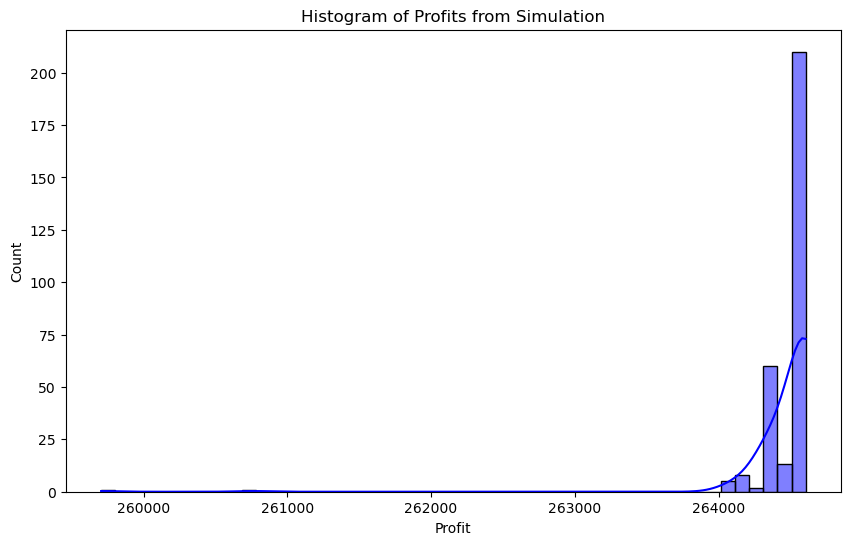

In [26]:
plot_simulation_profits(simulation_summary_list)


<span style="color:red">**Summary of the results for the best iteration of the simulations**</span>

In [27]:
get_best_simulation_summary(simulation_summary_list)

Best Simulation Summary: {'profit': 264605.0, 'total_cost': 53795.0, 'works_completed': 100, 'works_not_completed': 0}
Maximum Profit: 264605.0


<span style="color:red">**Assignment Graph for the best iteration of the simulations**</span>

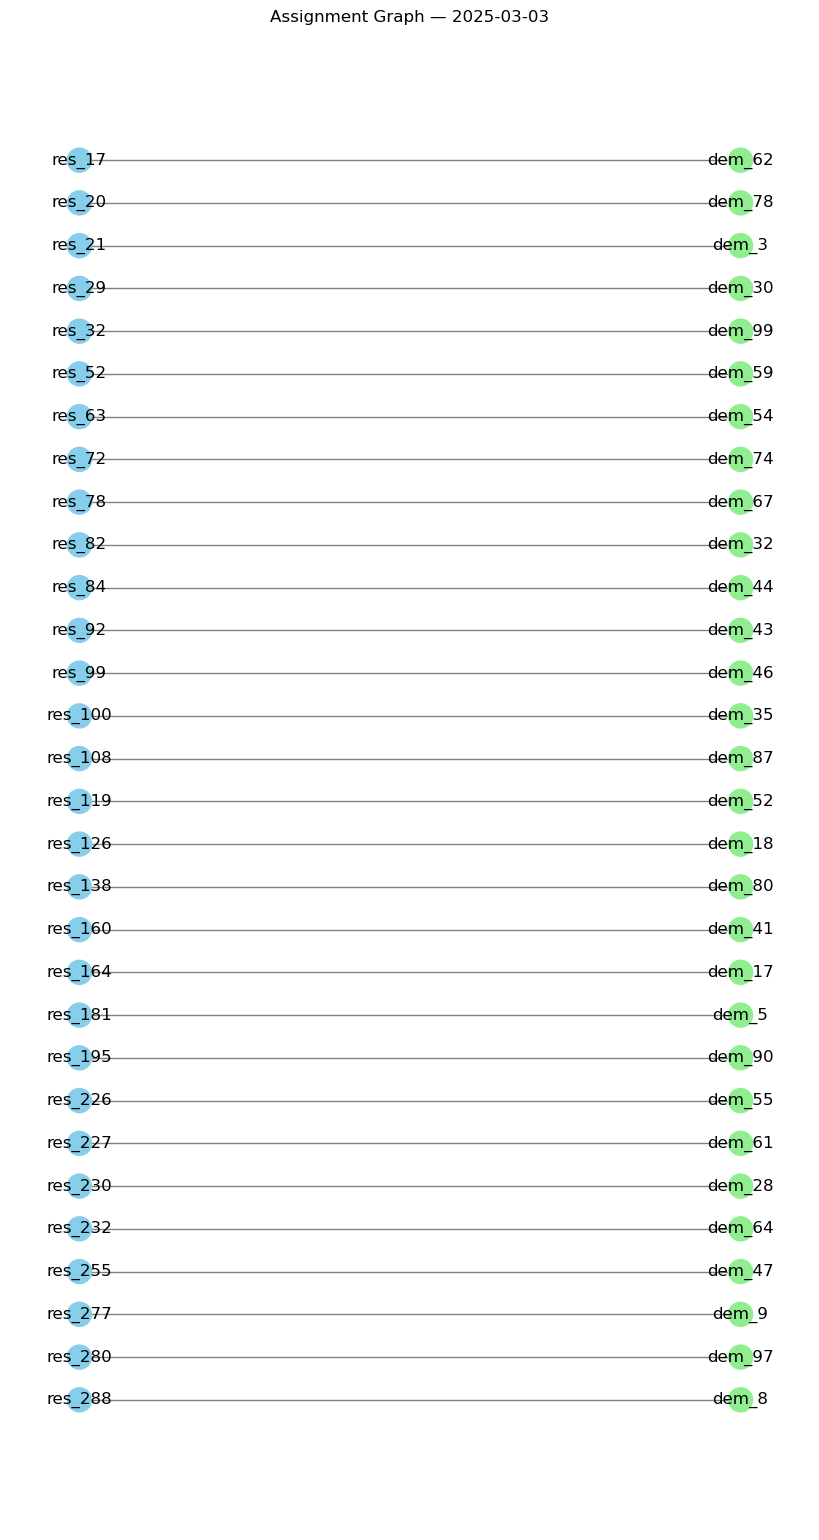

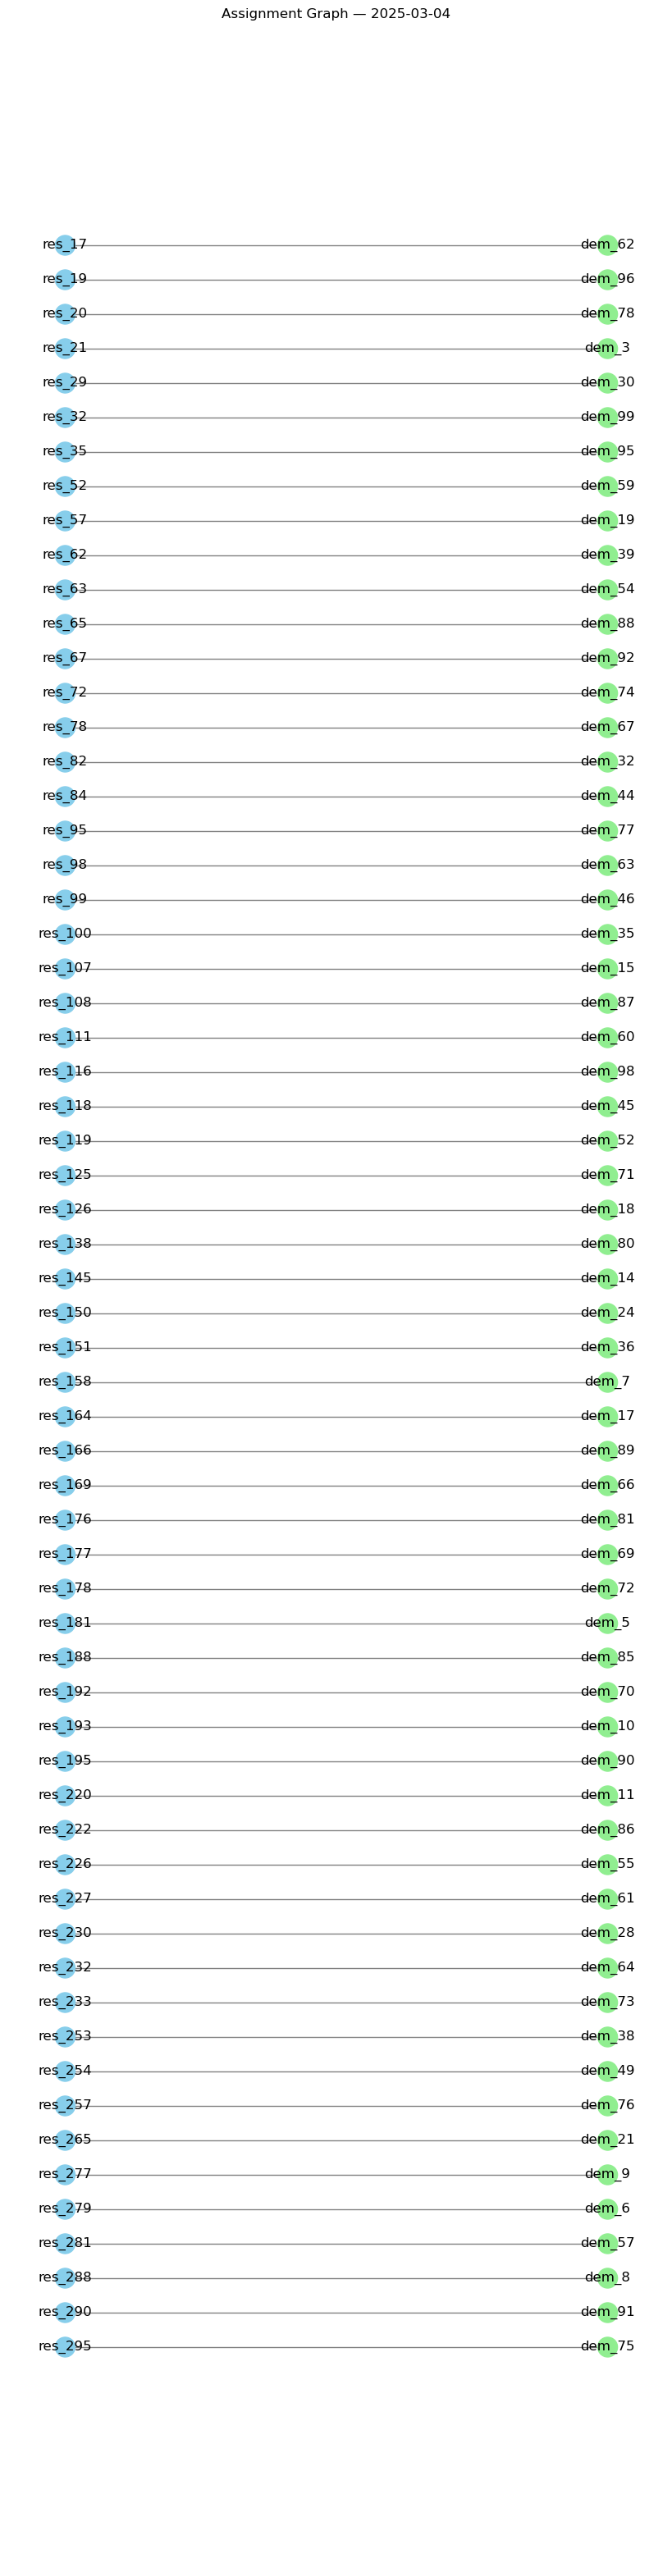

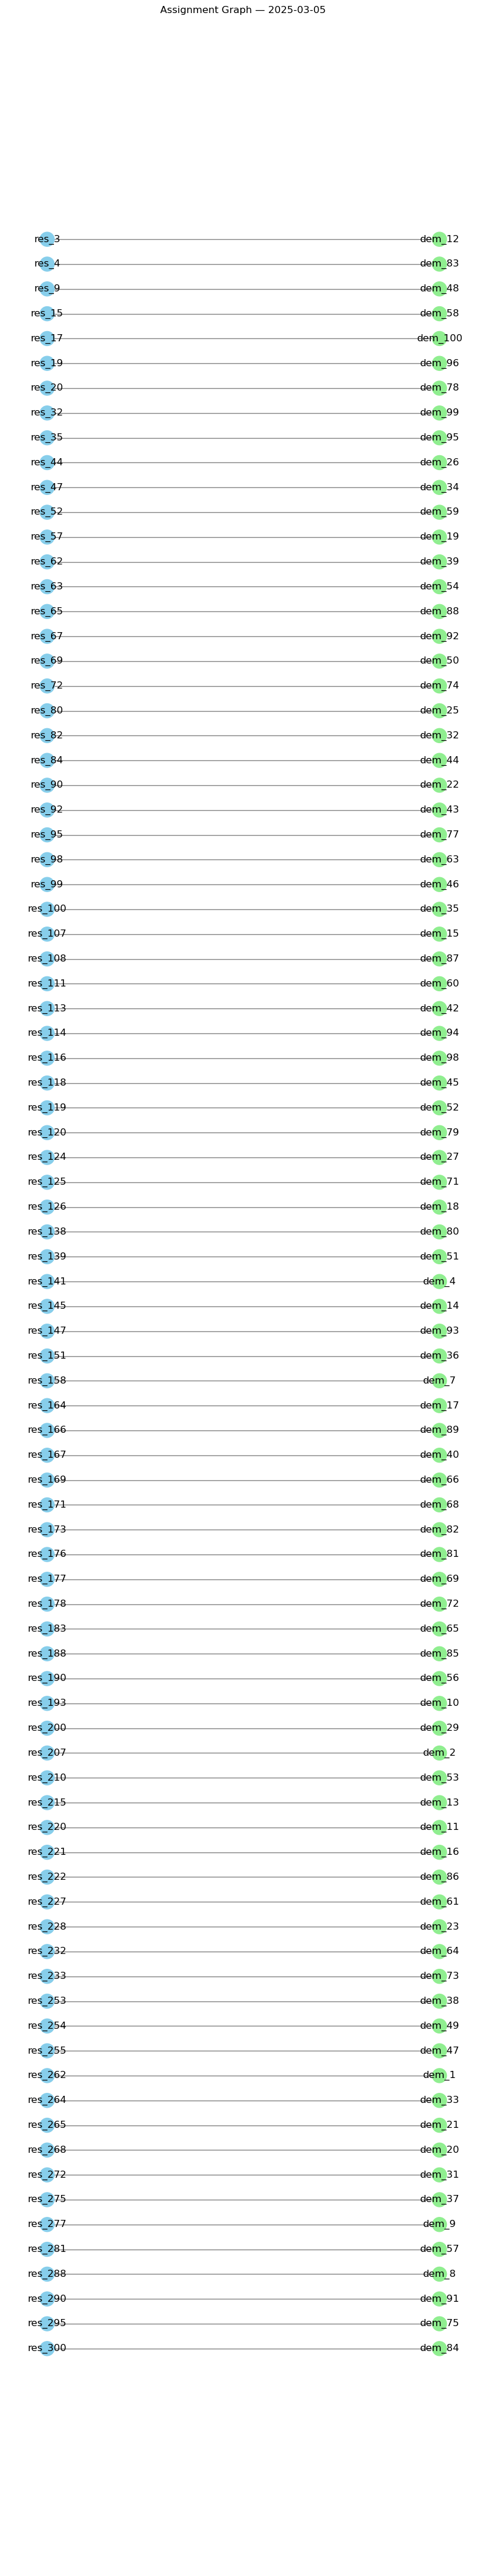

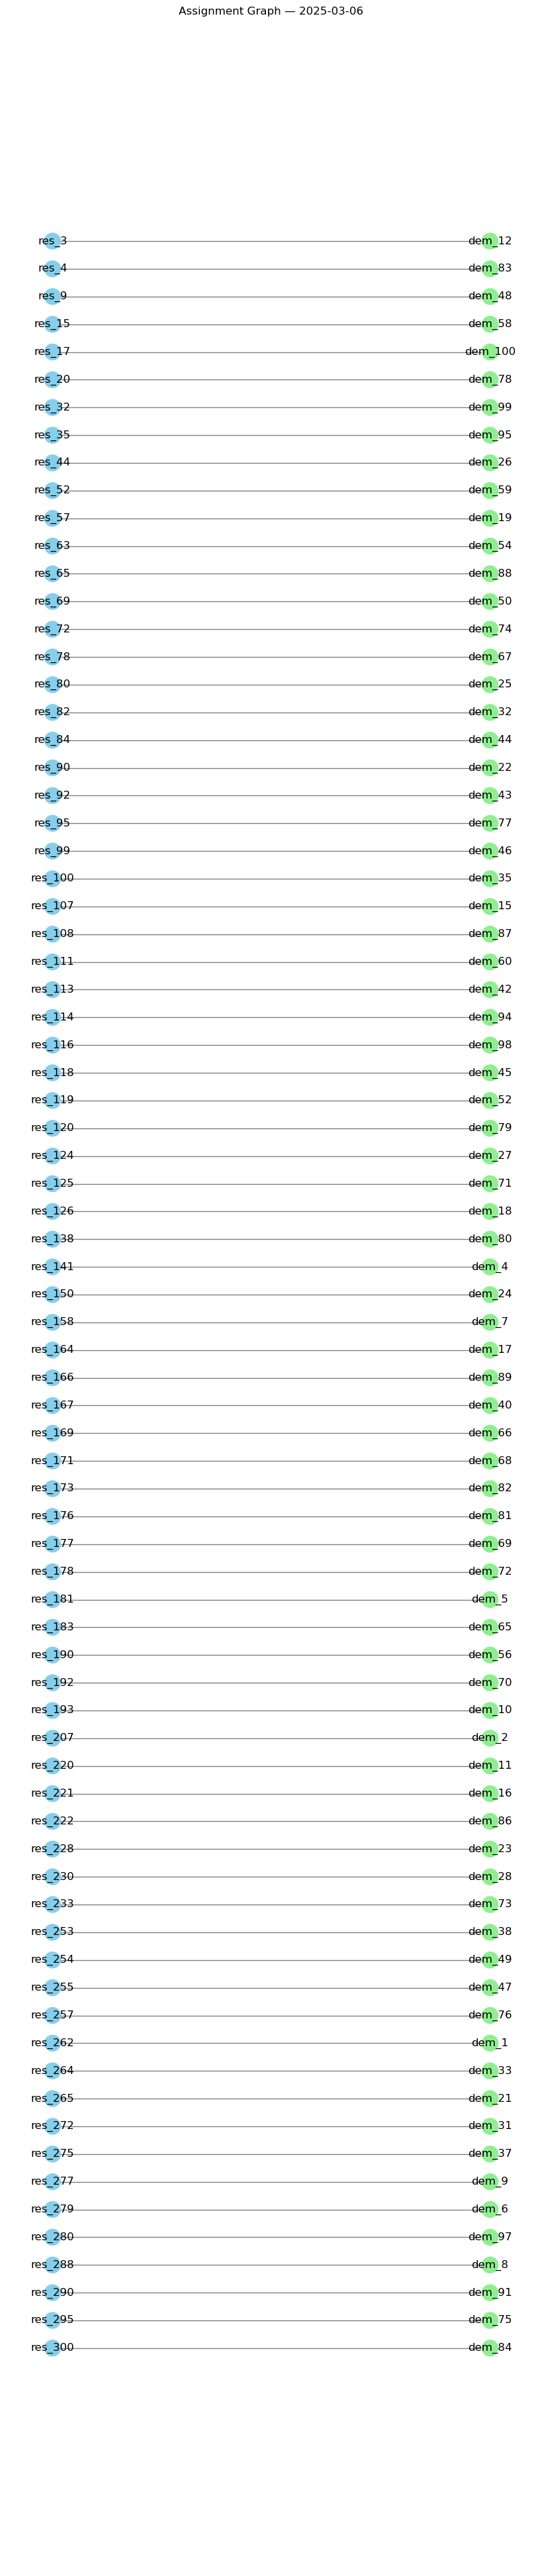

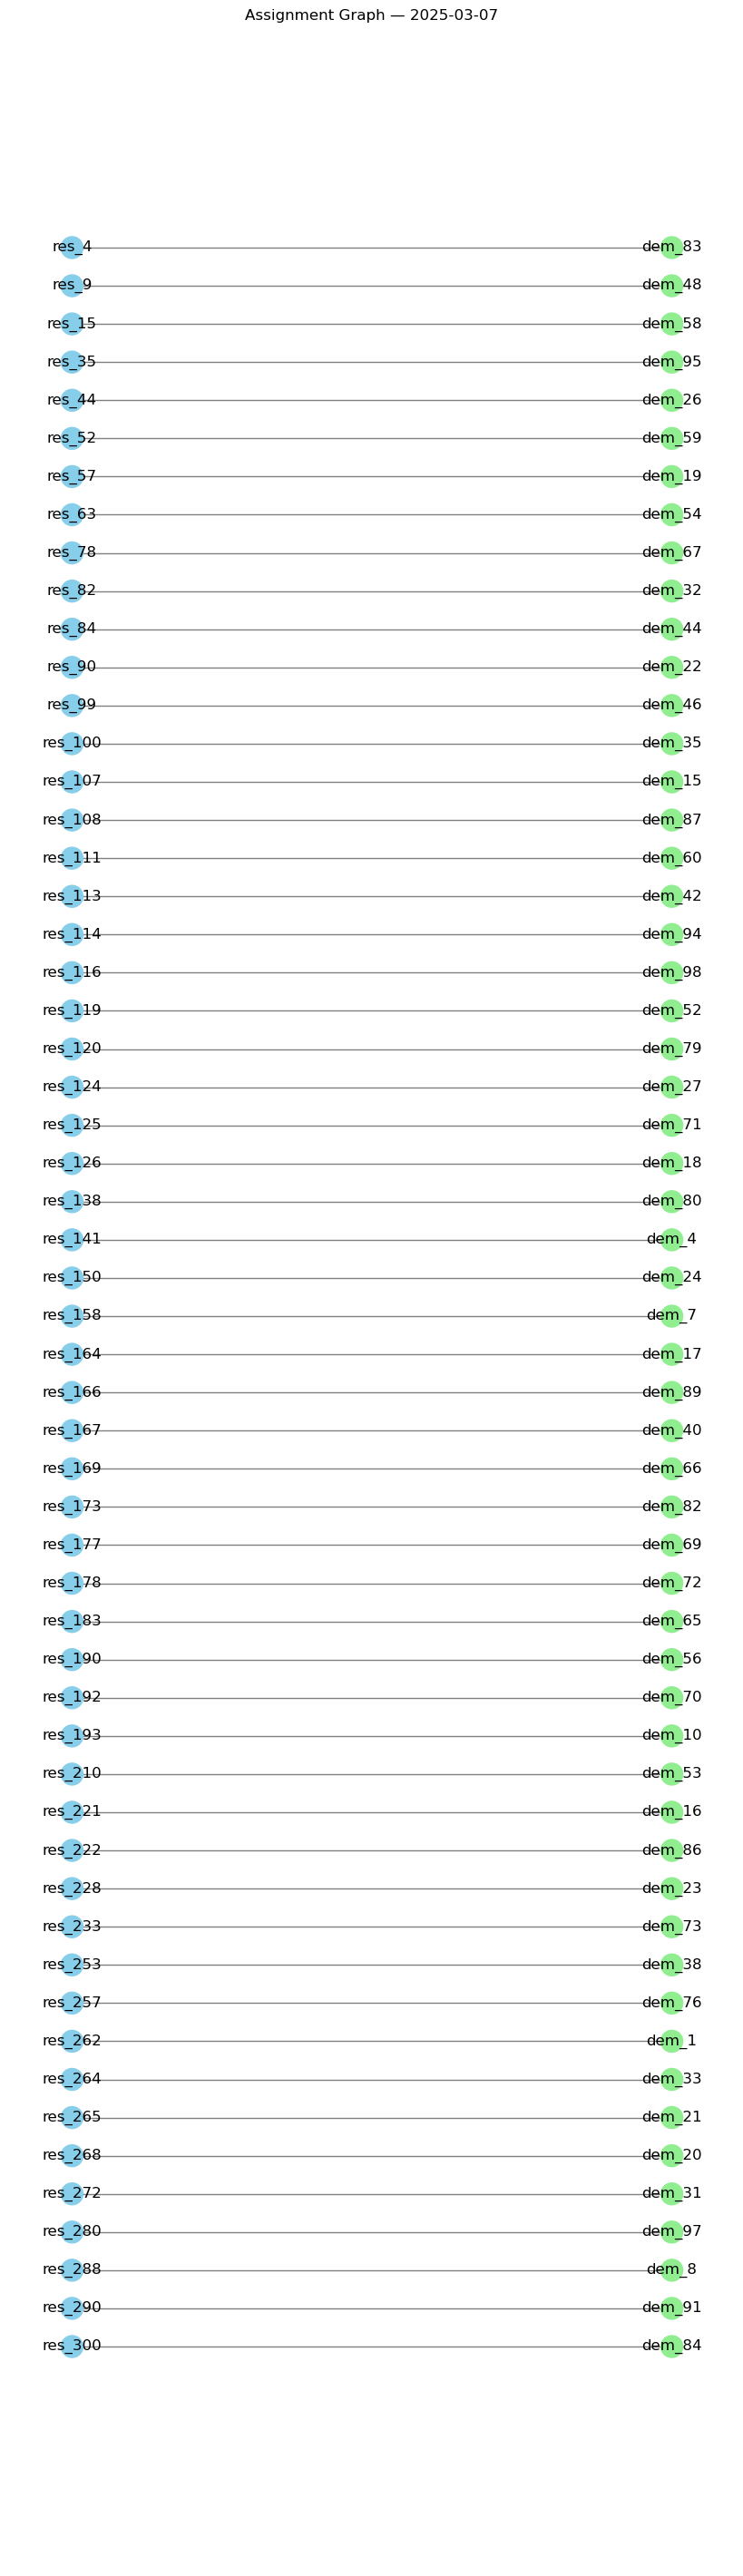

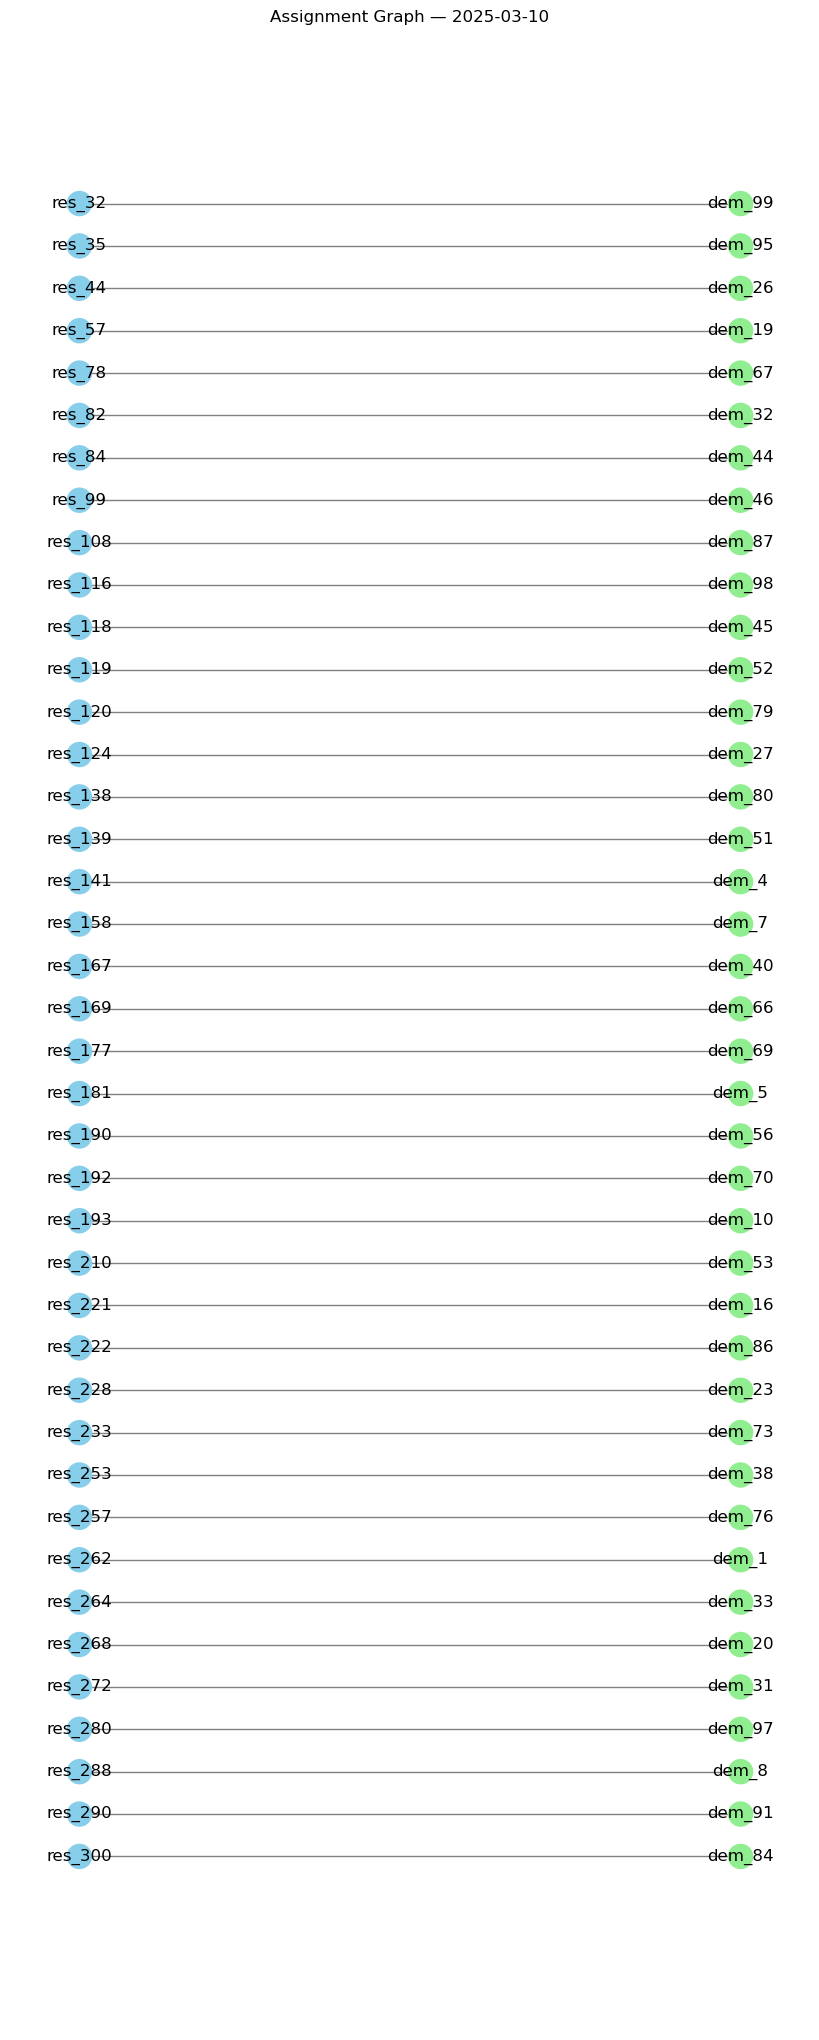

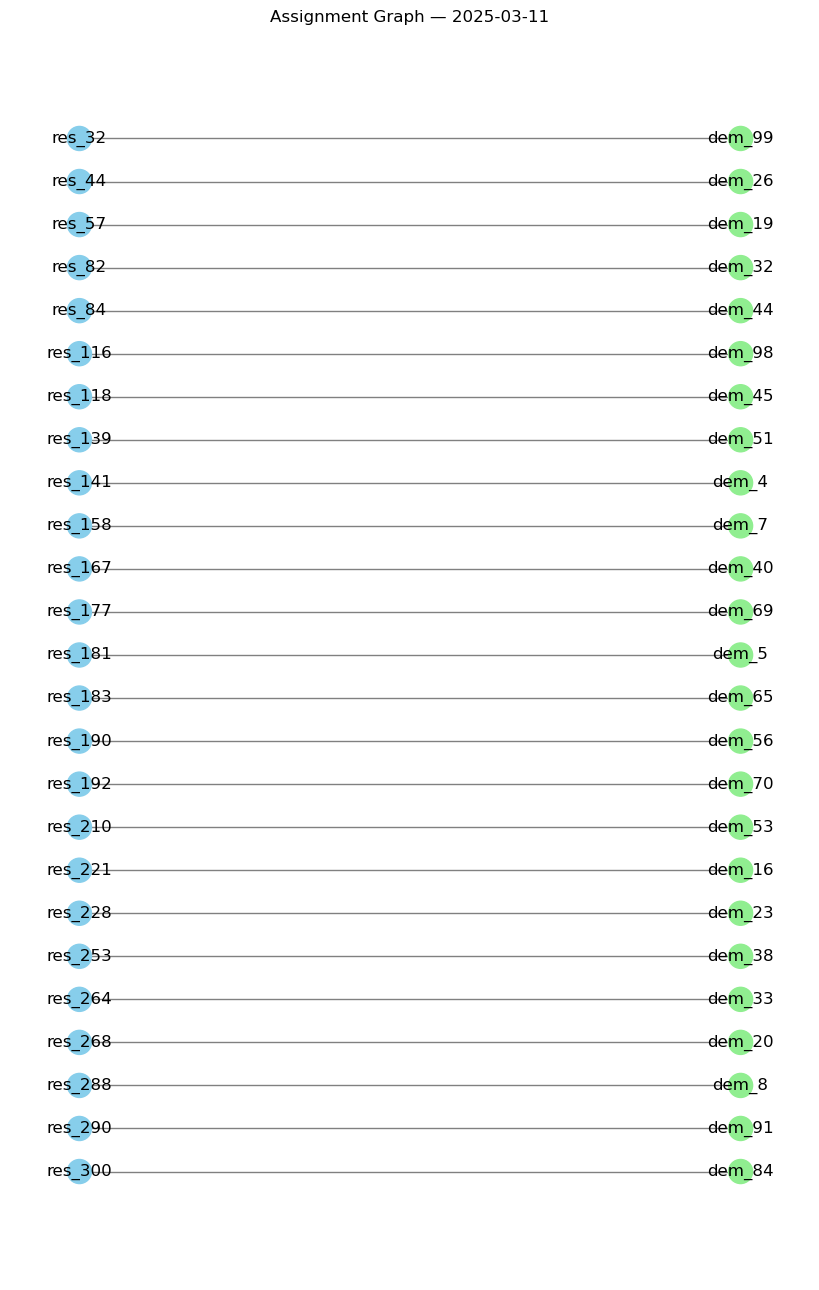

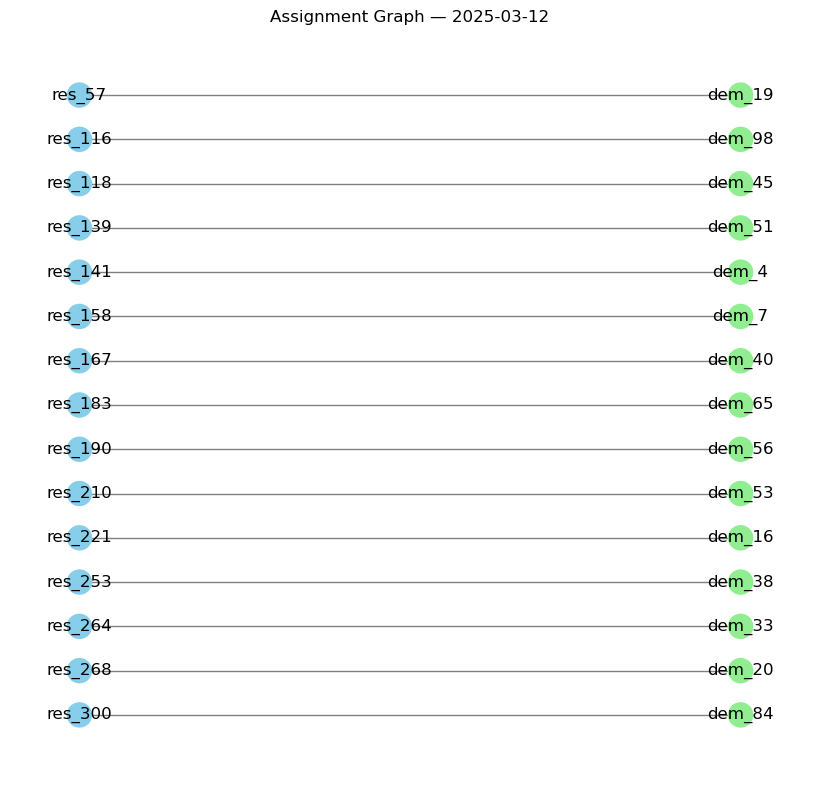

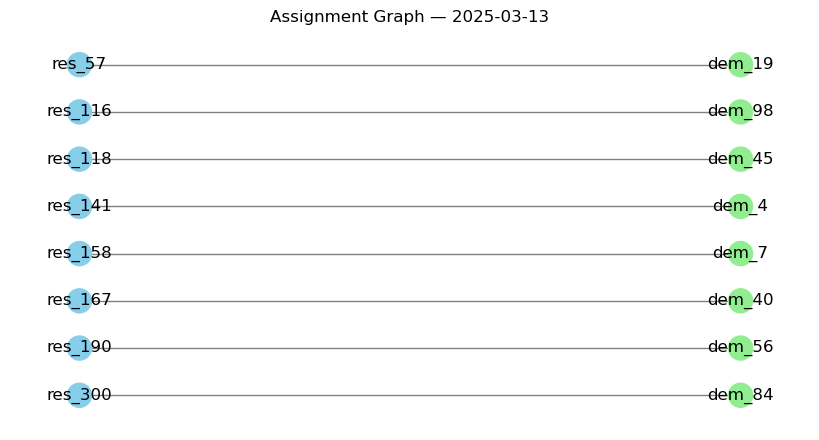

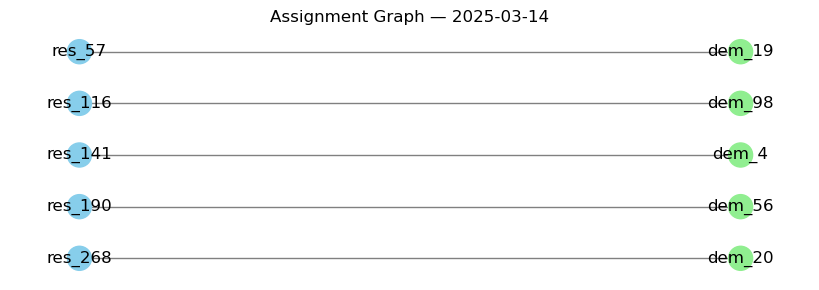

In [28]:
plot_best_simulation(simulation_summary_list, assignments_log_list)


<span style="color:red">**Initial demands and resources dataframes**</span>

In [29]:
demands

,demands_id,skill_required,languages_required,begin_date,end_date,total_workload,revenue,cost_not_completed
0,1,3,{English},2025-03-05,2025-03-10,12,2900,580.0
1,2,1,{English},2025-03-05,2025-03-14,10,1700,340.0
2,3,3,"{Spanish, English}",2025-03-03,2025-03-09,14,3300,660.0
3,4,3,{English},2025-03-05,2025-03-14,40,5700,1140.0
4,5,1,"{Spanish, English}",2025-03-03,2025-03-12,30,3900,780.0
...,...,...,...,...,...,...,...,...
95,96,1,{English},2025-03-04,2025-03-07,4,1100,220.0
96,97,2,"{Spanish, English}",2025-03-03,2025-03-15,26,4000,800.0
97,98,1,"{Spanish, English}",2025-03-04,2025-03-14,44,5300,1060.0
98,99,3,"{Spanish, English}",2025-03-03,2025-03-12,40,5900,1180.0


In [30]:
resources

,resources_id,skill_level,spoken_languages,Monday,Tuesday,Wednesday,Thursday,Friday,cost_per_hour
0,1,3,{English},4,3,3,2,1,35
1,2,3,{Spanish},0,0,1,3,3,35
2,3,3,{English},8,6,3,7,4,35
3,4,1,{Spanish},5,4,2,3,5,15
4,5,1,{Spanish},1,5,5,4,0,15
...,...,...,...,...,...,...,...,...,...
295,296,1,"{Spanish, English}",1,8,3,8,2,20
296,297,3,"{Spanish, English}",4,4,4,7,2,40
297,298,1,{Spanish},4,6,4,7,1,15
298,299,2,"{Spanish, English}",3,7,1,2,4,30
